# Analisi del processo di acquisizione cliente

Questo notebook contiene le analisi riguardanti il processo di acquisizione dei clienti tramite l'app Gimme 5.

Gli obiettivi dell'analisi sono:
 * Descrivere il processo attuale
 * Evidenziare eventuali opportunità per migliorare il processo al fine di aumentare la conversion rate

### Definizioni preliminari

Import necessari all'analisi.

In [1]:
conda install -c conda-forge plotnine

Solving environment: ...working... done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
from datetime import datetime


%matplotlib inline

La funzione **processFunnelData** prende in ingresso un dataframe e calcola le statistiche necessarie per valutare la progressione nel funnel. I calcoli effettuati sono brevemente descritti nei commenti e più in dettaglio in sezioni successive del notebook.

In [3]:
def processFunnelData(df):
    # il dataframe df deve essere strutturato in modo che
    # * ogni riga rappresenti uno step del funnel (id numerico nella colonna stage e descrizione nella colonna Stato_Utente)
    # * le colonne si dividono in:
    #   - colonne indice che contengono variabili descrittive (es. Stato_Utente)
    #   - colonne che rappresentano variabili in base a cui sezionare l'analisi del funnel (es. anno di sottoscrizione, importo bonus, ...)
    
    funnelData = df.copy()
    
    # definizione delle colonne indice che vengono escluse dall'analisi
    indexCols = ["Registration_Step","Registration_SubStep","Description_Registration_Step","User_Status_Detail"]
    varCols = [x for x in df.columns.tolist() if x not in indexCols]
    
    # per ogni variabile su cui valutare la progressine nel funnel vengono calcolate diverse statistiche
    # (si ricordi che ogni riga rappresenta uno stato del funnel) 
    for col in varCols:
        funnelData.sort_values(by="stage", ascending=False, inplace=True)
        
        # *col*_funnelProgression contiene l'avanzamento progressivo nel funnel. Per ogni riga, questa
        # statistica indica quante leads hanno completato il relativo step del processo di registrazione
        # o uno step successivo.
        funnelData["{}_funnelProgression".format(col)] = funnelData[col].cumsum()
        funnelData.sort_values(by="stage", ascending=True, inplace=True)
        
        # *col*_startingFrom è una variabile di supporto che indica quante leads hanno completato
        # lo step precedente
        funnelData["{}_startingFrom".format(col)] = funnelData["{}_funnelProgression".format(col)].shift()
        
        # *col*_stageLoss indica quante leads sono arrivate allo stage relativo alla riga,
        # ma non lo hanno completato
        funnelData["{}_stageLoss".format(col)] = funnelData["{}_funnelProgression".format(col)].diff()
        
        # *col*_keptStage indica la completion rate del singolo stage del funnel. Il valore in questa
        # colonna è la percentuale di leads che hanno completato lo step fatte 100 le lead che sono 
        # arrivate allo step. Es: un valore di 0.50 indica che su 100 leads arrivate allo step X, solo 50
        # lo hanno completato.
        funnelData["{}_keptStage".format(col)] = funnelData["{}_funnelProgression".format(col)]/funnelData["{}_startingFrom".format(col)]
        
        # *col*_keptOverll traccia in temini percentuali la progressione nel funnel. Il valore in questa
        # colonna è la percentuale di leads che hanno completato lo step fatte 100 le lead che hanno 
        # iniziato il processo di sottoscrizione. Es: un valore di 0.50 indica che su 100 leads che hanno
        # iniziato il processo di sottoscrizione, solo 50 sono arrivte a completare lo step X.
        funnelData["{}_keptOverall".format(col)]  = funnelData["{}_funnelProgression".format(col)]/funnelData["{}_funnelProgression".format(col)].max()
        
    return funnelData

## Caricamento dei dati e preprocessing

I dati vengono caricati e, dove necessario, le colonne vengono convertite nei formati opportuni (es. _datetime_).

In [4]:
a2users = pd.read_csv(r'C:\Users\elisa\Downloads\a2usersOK.csv',sep=';',low_memory=False)

In [5]:
a2users.head(10) #sex is 1 or 2 (anonymized this too)

,ID_User,ID_Promotion,ID_Promo_Code,Age,Sex,Email_Domain,Flag_User_Disabled,Date_Last_Access,Registration_Case,Description_Registration_Case,...,DateTime_First_Investment,Last_Online_Subscription,All_Online_Subscriptions,User_Status_Detail,subscr_year,subscr_month,infYear,infGender,ageAtSubscription,ageBand
0,1,32,40100.0,44.0,1,GMAIL,0.0,06/09/2019,1.0,Nuovo Utente,...,NaN,Gimme5,Gimme5,10 - Concluso,2019,3,1975.0,1,43,40-45
1,2,0,NaN,42.0,1,GMAIL,0.0,05/09/2019,1.0,Nuovo Utente,...,23/05/2018 00:00,Gimme5,Gimme5,10 - Concluso,2017,8,1976.0,1,40,40-45
2,3,35,40103.0,28.0,1,GMAIL,0.0,05/09/2019,1.0,Nuovo Utente,...,NaN,Gimme5,Gimme5,10 - Concluso,2019,3,1990.0,1,28,25-30
3,4,0,NaN,32.0,1,LIBERO,0.0,05/09/2019,1.0,Nuovo Utente,...,19/02/2019 00:00,Gimme5,Gimme5,10 - Concluso,2018,11,1987.0,1,31,30-35
4,5,0,NaN,26.0,1,HOTMAIL,0.0,05/09/2019,1.0,Nuovo Utente,...,26/11/2014 00:00,Gimme5,Gimme5,10 - Concluso,2014,11,1993.0,1,21,20-25
5,6,0,NaN,37.0,1,GMAIL,0.0,05/09/2019,1.0,Nuovo Utente,...,21/02/2018 00:00,Gimme5,Gimme5,10 - Concluso,2018,2,1982.0,1,35,35-40
6,7,0,NaN,62.0,1,GMAIL,0.0,06/09/2019,1.0,Nuovo Utente,...,17/05/2018 00:00,Gimme5,Gimme5,10 - Concluso,2018,5,1957.0,1,60,60-65
7,8,0,NaN,58.0,1,GMAIL,0.0,05/09/2019,1.0,Nuovo Utente,...,18/08/2018 00:00,Gimme5,Gimme5,10 - Concluso,2018,8,1961.0,1,57,55-60
8,9,0,NaN,30.0,1,GMAIL,0.0,05/09/2019,1.0,Nuovo Utente,...,05/09/2019 00:00,Gimme5,Gimme5,10 - Concluso,2018,1,1989.0,1,28,25-30
9,10,27,40087.0,43.0,1,HOTMAIL,0.0,05/09/2019,1.0,Nuovo Utente,...,NaN,Gimme5,Gimme5,10 - Concluso,2019,3,1976.0,1,43,40-45


In [6]:
exclude = a2users["Last_Online_Subscription"] == "AcomeA" #get rid of those customers coming from AcomeA NOT Gimme5
a2users = a2users[~exclude].copy() #~operator get the complementary

a2users["DateTime_Subscription"] = pd.to_datetime(a2users["DateTime_Subscription"]) #make the date in time format

In [7]:
a2users

,ID_User,ID_Promotion,ID_Promo_Code,Age,Sex,Email_Domain,Flag_User_Disabled,Date_Last_Access,Registration_Case,Description_Registration_Case,...,DateTime_First_Investment,Last_Online_Subscription,All_Online_Subscriptions,User_Status_Detail,subscr_year,subscr_month,infYear,infGender,ageAtSubscription,ageBand
0,1,32,40100.0,44.0,1,GMAIL,0.0,06/09/2019,1.0,Nuovo Utente,...,NaN,Gimme5,Gimme5,10 - Concluso,2019,3,1975.0,1,43,40-45
1,2,0,NaN,42.0,1,GMAIL,0.0,05/09/2019,1.0,Nuovo Utente,...,23/05/2018 00:00,Gimme5,Gimme5,10 - Concluso,2017,8,1976.0,1,40,40-45
2,3,35,40103.0,28.0,1,GMAIL,0.0,05/09/2019,1.0,Nuovo Utente,...,NaN,Gimme5,Gimme5,10 - Concluso,2019,3,1990.0,1,28,25-30
3,4,0,NaN,32.0,1,LIBERO,0.0,05/09/2019,1.0,Nuovo Utente,...,19/02/2019 00:00,Gimme5,Gimme5,10 - Concluso,2018,11,1987.0,1,31,30-35
4,5,0,NaN,26.0,1,HOTMAIL,0.0,05/09/2019,1.0,Nuovo Utente,...,26/11/2014 00:00,Gimme5,Gimme5,10 - Concluso,2014,11,1993.0,1,21,20-25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217709,217710,0,NaN,0.0,3,MAILINATOR,0.0,28/04/2015,0.0,Non Definito,...,NaN,NaN,NaN,Utente Test,2015,4,0.0,3,0,NotAv
217710,217711,0,NaN,0.0,3,CLRMAIL,1.0,13/04/2016,0.0,Non Definito,...,NaN,NaN,NaN,0 - E-Mail non verificata,2016,4,0.0,3,0,NotAv
217711,217712,0,NaN,0.0,3,GMAIL,0.0,10/06/2017,0.0,Non Definito,...,NaN,NaN,NaN,2 - Sottoscrizione Iniziata,2017,6,0.0,3,0,NotAv
217712,217713,0,NaN,0.0,3,GMAIL,0.0,24/09/2014,0.0,Non Definito,...,01/06/2018 00:00,NaN,NaN,Anomalia No Iscrizione,0,0,1967.0,3,0,NotAv


In [8]:
a2users.columns

Index(['ID_User', 'ID_Promotion', 'ID_Promo_Code', 'Age', 'Sex',
       'Email_Domain', 'Flag_User_Disabled', 'Date_Last_Access',
       'Registration_Case', 'Description_Registration_Case',
       'Registration_Step', 'Registration_SubStep',
       'Description_Registration_Step', 'User_Status', 'has_ID_Facebook',
       'has_ID_GPlus', 'User_Class', 'Flag_Test_User', 'Residence_Province',
       'Favourite_Contract_Class', 'Activation_Payment_Method',
       'Payment_Method', 'Subscription_Bonus', 'DateTime_First_Login',
       'First_Login_Type', 'First_Login_Asset', 'DateTime_Last_Login',
       'Last_Login_Type', 'Last_Login_Asset', 'DateTime_Subscription',
       'DateTime_First_Conclusion', 'DateTime_Last_Conclusion',
       'DateTime_First_Investment', 'Last_Online_Subscription',
       'All_Online_Subscriptions', 'User_Status_Detail', 'subscr_year',
       'subscr_month', 'infYear', 'infGender', 'ageAtSubscription', 'ageBand'],
      dtype='object')

Per le analisi vengono considerate solo le leads generate attraverso il processo di sottoscrizione corrente (ovvero create dopo il 01/10/2017.

In [9]:
subset = a2users["DateTime_Subscription"].apply(lambda x: x>datetime(2017,10,1))
a2users = a2users[subset].copy()
del subset #get rid of all the info about subscriptions before that time

In [10]:
#subset2 = a2users["DateTime_Subscription"].apply(lambda x: x>datetime(2019,10,1))
#this can be used if we want to merge info in the subscription table and the funnel table
#since users in the subscription table are considered from Oct 2019

Esplorazione prelinimare (colonne disponibili, analisi stato utente ed età).

In [11]:
a2users.columns

Index(['ID_User', 'ID_Promotion', 'ID_Promo_Code', 'Age', 'Sex',
       'Email_Domain', 'Flag_User_Disabled', 'Date_Last_Access',
       'Registration_Case', 'Description_Registration_Case',
       'Registration_Step', 'Registration_SubStep',
       'Description_Registration_Step', 'User_Status', 'has_ID_Facebook',
       'has_ID_GPlus', 'User_Class', 'Flag_Test_User', 'Residence_Province',
       'Favourite_Contract_Class', 'Activation_Payment_Method',
       'Payment_Method', 'Subscription_Bonus', 'DateTime_First_Login',
       'First_Login_Type', 'First_Login_Asset', 'DateTime_Last_Login',
       'Last_Login_Type', 'Last_Login_Asset', 'DateTime_Subscription',
       'DateTime_First_Conclusion', 'DateTime_Last_Conclusion',
       'DateTime_First_Investment', 'Last_Online_Subscription',
       'All_Online_Subscriptions', 'User_Status_Detail', 'subscr_year',
       'subscr_month', 'infYear', 'infGender', 'ageAtSubscription', 'ageBand'],
      dtype='object')

In [12]:
a2users["User_Status_Detail"].value_counts() #for each status check they are not the same and also get rid of 
#the 'Solo su AcomeA-Online' since we already filter by AcomeA before.
#User Test is NOISE: eliminated
#User canceled gives instead info: they canceled before termining the subscription process.
#Here we are performing another kind of analysis and we get rid also of Canceled User but it actually is informative

2 - Sottoscrizione Iniziata    44834
1 - Mail Validata              17314
10 - Concluso                  15636
5 - Residenza OK                9036
0 - E-Mail non verificata       8733
8 - Antiriciclaggio OK          7068
4 - Dati Personali OK           2854
3 - Codice Fiscale OK           2658
Utente Cancellato               1786
6 - Documento ID OK             1660
9 - Fondo Scelto                1230
7 - Documenti Firmati            386
Utente Test                      207
A - Solo su AcomeA-Online         25
Name: User_Status_Detail, dtype: int64

In [13]:
a2users["ageBand"].value_counts()

NotAv    70597
20-25     8703
25-30     8173
30-35     6342
35-40     4899
40-45     4139
18-20     4041
45-50     2877
50-55     1900
55-60      916
65+        428
60-65      412
Name: ageBand, dtype: int64

L'anno di sottoscrizione (colonna _subscr_year_) viene inizializzato a 0 per i casi in cui risulta mancante (_NaN_) e convertito a int.

In [14]:
a2users.loc[pd.isna(a2users["subscr_year"]),"subscr_year"] = 0             #subscript. year = 0 must be canceled
a2users["subscr_year"] = a2users["subscr_year"].astype(int)         #set to integers these years

Viene definita la variabile _stage_ - variabile numerica che descrive la progressione nel funnel come definito da _Stato_Utente_ in modo descrittivo.
Vengono scartati
* gli utenti che hanno come stato "A - Solo su AcomeA-online" - ovvero utenti non Gimme5
* gli utenti che non hanno uno stato utente valido ( _stage_ == -1)

In [15]:
# move into make_dataset.py or into the data extraction queries
a2users = a2users[a2users["User_Status_Detail"]!="A - Solo su AcomeA-Online"].copy()

a2users["stage"] = -1 
#users are classified in stage = -1 by default, but if they have User_Status_Detail as follow they are reclassified

a2users.loc[a2users["User_Status_Detail"]=="0 - E-Mail non verificata","stage"] = 0 
#set =0 the values of the User_Status_Detail col equal to "0 - E-Mail non verificata" and add column "stage"
a2users.loc[a2users["User_Status_Detail"]=="1 - Mail Validata","stage"] = 1
a2users.loc[a2users["User_Status_Detail"]=="2 - Sottoscrizione Iniziata","stage"] = 2
a2users.loc[a2users["User_Status_Detail"]=="3 - Codice Fiscale OK","stage"] = 3
a2users.loc[a2users["User_Status_Detail"]=="4 - Dati Personali OK","stage"] = 4
a2users.loc[a2users["User_Status_Detail"]=="5 - Residenza OK","stage"] = 5
a2users.loc[a2users["User_Status_Detail"]=="6 - Documento ID OK","stage"] = 6
a2users.loc[a2users["User_Status_Detail"]=="7 - Documenti Firmati","stage"] = 7
a2users.loc[a2users["User_Status_Detail"]=="8 - Antiriciclaggio OK","stage"] = 8
a2users.loc[a2users["User_Status_Detail"]=="9 - Fondo Scelto","stage"] = 9
a2users.loc[a2users["User_Status_Detail"]=="10 - Concluso","stage"] = 10

a2users = a2users[a2users["stage"]>-1].copy() #we get rid of those that are stacked at stage, but actually we already done this by
# get rid of the User test and Canceled User

In [16]:
a2users.head()

,ID_User,ID_Promotion,ID_Promo_Code,Age,Sex,Email_Domain,Flag_User_Disabled,Date_Last_Access,Registration_Case,Description_Registration_Case,...,Last_Online_Subscription,All_Online_Subscriptions,User_Status_Detail,subscr_year,subscr_month,infYear,infGender,ageAtSubscription,ageBand,stage
0,1,32,40100.0,44.0,1,GMAIL,0.0,06/09/2019,1.0,Nuovo Utente,...,Gimme5,Gimme5,10 - Concluso,2019,3,1975.0,1,43,40-45,10
2,3,35,40103.0,28.0,1,GMAIL,0.0,05/09/2019,1.0,Nuovo Utente,...,Gimme5,Gimme5,10 - Concluso,2019,3,1990.0,1,28,25-30,10
3,4,0,NaN,32.0,1,LIBERO,0.0,05/09/2019,1.0,Nuovo Utente,...,Gimme5,Gimme5,10 - Concluso,2018,11,1987.0,1,31,30-35,10
5,6,0,NaN,37.0,1,GMAIL,0.0,05/09/2019,1.0,Nuovo Utente,...,Gimme5,Gimme5,10 - Concluso,2018,2,1982.0,1,35,35-40,10
6,7,0,NaN,62.0,1,GMAIL,0.0,06/09/2019,1.0,Nuovo Utente,...,Gimme5,Gimme5,10 - Concluso,2018,5,1957.0,1,60,60-65,10


Viene creata una variabile che descrive il tipo di login effettuato dall'utente (_inf_loginType_).
I valori possono essere: _Facebook_, _Google_, _Multi_ (l'utente ha utilizzato sia _Facebook_ che _Google_), _Altri_ (l'utente ha effettuato il login creando un utente tramite indirizzo email).

In [17]:
a2users["has_ID_GPlus"]==0

0         False
2          True
3          True
5          True
6          True
          ...  
217687     True
217691     True
217694     True
217695     True
217704     True
Name: has_ID_GPlus, Length: 111409, dtype: bool

In [18]:
a2users["inf_loginType"] = "Altri" #create also another column called "inf_loginType" and set its default value equal to "Altri"

#Then those who have these characteristics will change the default value for column "inf_loginType"
fb = (a2users["has_ID_Facebook"]==1) & (a2users["has_ID_GPlus"]==0)
a2users.loc[fb,"inf_loginType"] = "Facebook"

gp = (a2users["has_ID_Facebook"]==0) & (a2users["has_ID_GPlus"]==1)
a2users.loc[gp,"inf_loginType"] = "Google"

multi = (a2users["has_ID_Facebook"]==1) & (a2users["has_ID_GPlus"]==1)
a2users.loc[multi,"inf_loginType"] = "Multi"

In [19]:
a2users["inf_loginType"].value_counts()

Altri       76757
Facebook    20511
Google      13954
Multi         187
Name: inf_loginType, dtype: int64

## Inizio analisi del processo di sottoscrizione

Il dataframe che contiene i dati utente viene riaggregato per poter analizare la progressione nel funnel nei diversi anni.

In [20]:
funnelDataY = a2users.groupby(["stage","User_Status_Detail","subscr_year"])["ID_User"].count().reset_index()
#group by these columns and count the userid for each
funnelDataY
#so for each stage and aech of the three considered years we count the user_id in order to see the funnel

,stage,User_Status_Detail,subscr_year,ID_User
0,0,0 - E-Mail non verificata,2017,1258
1,0,0 - E-Mail non verificata,2018,4210
2,0,0 - E-Mail non verificata,2019,3265
3,1,1 - Mail Validata,2017,2366
4,1,1 - Mail Validata,2018,8078
5,1,1 - Mail Validata,2019,6870
6,2,2 - Sottoscrizione Iniziata,2017,4217
7,2,2 - Sottoscrizione Iniziata,2018,25042
8,2,2 - Sottoscrizione Iniziata,2019,15575
9,3,3 - Codice Fiscale OK,2017,258


Il dataframe _funnelData_ viene riorganizzato in formato "tabulare": ogni riga rappresenta un passo specifico del processo di sottoscrizione, le colonne rappresentano i diversi anni. Il valore di ogni cella (riga _s_ - colonna _y_) rappresenta il numero di leads create in un anno (_y_) e attualmente ferme in uno stato (_s_).

In [21]:
funnelStageYear = pd.pivot_table(funnelDataY, index=["stage","User_Status_Detail"],columns="subscr_year",values="ID_User")
#we alsp run a pivot to understand

In [22]:
funnelStageYear #how many user ids are stacked for each step in each year
# gimme5 spent a lot of budget in get them know to a lot of people, but there are too many email non verificata that means a 
# totally loose of budget

,subscr_year,2017,2018,2019
stage,User_Status_Detail,,,
0,0 - E-Mail non verificata,1258,4210,3265
1,1 - Mail Validata,2366,8078,6870
2,2 - Sottoscrizione Iniziata,4217,25042,15575
3,3 - Codice Fiscale OK,258,1244,1156
4,4 - Dati Personali OK,205,1459,1190
5,5 - Residenza OK,565,4299,4172
6,6 - Documento ID OK,190,971,499
7,7 - Documenti Firmati,89,187,110
8,8 - Antiriciclaggio OK,394,3410,3264


Il dataframe in formato tabulare (_funnelStageYear_) viene processato per calcolare le statistiche necessarie per valutare la progressione attraverso il funnel delle leads - sezionando l'analisi per anno di sottoscrizione.
Le variabili descritte nella definizione della funzione **processFunnelData** sono calcolate e restituite in output per ogni anno.
In altre parole, il dataset conterrà le colonne:
* \*anno\*_funnelProgression
* \*anno\*_startingFrom
* \*anno\*_stageLoss
* \*anno\*_keptStage
* \*anno\*_keptOverall

per ogni \*anno\* contenuto nel dataframe (attualmente 2017, 2018, 2019).

In [23]:
funnelProgrSY = processFunnelData(funnelStageYear.reset_index())
#cols = ["User_Status_Detail",2017,2018,2019,"2017_keptOverall","2018_keptOverall","2019_keptOverall"] #normalized to 1 values
cols = ["User_Status_Detail",2017,2018,2019,"2017_keptStage","2018_keptStage","2019_keptStage"]
funnelProgrSY[cols]

subscr_year,User_Status_Detail,2017,2018,2019,2017_keptStage,2018_keptStage,2019_keptStage
0,0 - E-Mail non verificata,1258,4210,3265,NaN,NaN,NaN
1,1 - Mail Validata,2366,8078,6870,0.886040,0.926940,0.923619
2,2 - Sottoscrizione Iniziata,4217,25042,15575,0.758102,0.848766,0.825992
3,3 - Codice Fiscale OK,258,1244,1156,0.431288,0.447635,0.522400
4,4 - Dati Personali OK,205,1459,1190,0.919325,0.938701,0.932144
5,5 - Residenza OK,565,4299,4172,0.930272,0.923412,0.925063
6,6 - Documento ID OK,190,971,499,0.793419,0.755614,0.715997
7,7 - Documenti Firmati,89,187,110,0.912442,0.926949,0.952558
8,8 - Antiriciclaggio OK,394,3410,3264,0.955051,0.984823,0.989021
9,9 - Fondo Scelto,13,376,841,0.791645,0.718971,0.670602


we can see that in 2017 about an half of the validated mail 
Note that after setting the fiscal code, people go through the process: the 90% of those inserting the fiscal code then insert also the personal data

In [24]:
funnelProgrSY = processFunnelData(funnelStageYear.reset_index())
#cols = ["User_Status_Detail",2017,2018,2019,"2017_keptOverall","2018_keptOverall","2019_keptOverall"]
cols = ["User_Status_Detail",2017,2018,2019,"2017_keptStage","2018_keptStage","2019_keptStage"]
funnelProgrSY[cols]

subscr_year,User_Status_Detail,2017,2018,2019,2017_keptStage,2018_keptStage,2019_keptStage
0,0 - E-Mail non verificata,1258,4210,3265,NaN,NaN,NaN
1,1 - Mail Validata,2366,8078,6870,0.886040,0.926940,0.923619
2,2 - Sottoscrizione Iniziata,4217,25042,15575,0.758102,0.848766,0.825992
3,3 - Codice Fiscale OK,258,1244,1156,0.431288,0.447635,0.522400
4,4 - Dati Personali OK,205,1459,1190,0.919325,0.938701,0.932144
5,5 - Residenza OK,565,4299,4172,0.930272,0.923412,0.925063
6,6 - Documento ID OK,190,971,499,0.793419,0.755614,0.715997
7,7 - Documenti Firmati,89,187,110,0.912442,0.926949,0.952558
8,8 - Antiriciclaggio OK,394,3410,3264,0.955051,0.984823,0.989021
9,9 - Fondo Scelto,13,376,841,0.791645,0.718971,0.670602


It is the same table but a funnel visualizations, how many clients are left at each step?

Il dataframe viene riorganizzato per poter essere visualizzato tramite plotnine (clone Python di ggplot2).

In [25]:
categories = funnelProgrSY["User_Status_Detail"].values
dfSY = pd.melt(funnelProgrSY[["User_Status_Detail","2017_keptOverall","2018_keptOverall","2019_keptOverall"]], id_vars="User_Status_Detail")

In [26]:
from plotnine import ggplot, geom_col, scale_x_discrete, coord_flip, facet_wrap, aes

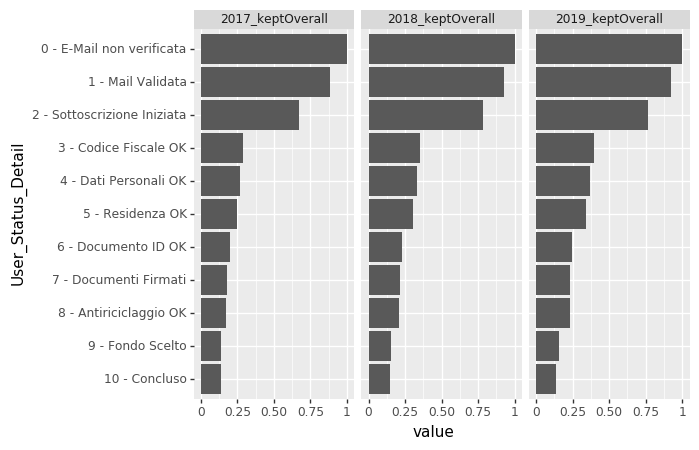

<ggplot: (-9223371851823802188)>

In [27]:
( ggplot(dfSY)
 + geom_col(aes(x="User_Status_Detail", y="value"))
 + scale_x_discrete(limits=categories[::-1])
 + coord_flip()
 + facet_wrap("subscr_year")
)

Analisi del funnel ripetuta sezionando per tipo di login. 

In [28]:
funnelDataLog = a2users.groupby(["stage","User_Status_Detail","inf_loginType"])["ID_User"].count().reset_index()
funnelStageLog = pd.pivot_table(funnelDataLog, index=["stage","User_Status_Detail"],columns="inf_loginType",values="ID_User",fill_value=0)

funnelProgrSL = processFunnelData(funnelStageLog.reset_index())
funnelProgrSL[["User_Status_Detail","Altri","Facebook","Google","Multi","Altri_keptOverall","Facebook_keptOverall","Google_keptOverall","Multi_keptOverall"]]

inf_loginType,User_Status_Detail,Altri,Facebook,Google,Multi,Altri_keptOverall,Facebook_keptOverall,Google_keptOverall,Multi_keptOverall
0,0 - E-Mail non verificata,8733,0,0,0,1.000000,1.000000,1.000000,1.000000
1,1 - Mail Validata,8772,5912,2627,3,0.886225,1.000000,1.000000,1.000000
2,2 - Sottoscrizione Iniziata,27733,9830,7218,53,0.771943,0.711764,0.811739,0.983957
3,3 - Codice Fiscale OK,2030,376,250,2,0.410634,0.232509,0.294468,0.700535
4,4 - Dati Personali OK,2011,511,332,0,0.384186,0.214178,0.276552,0.689840
5,5 - Residenza OK,6834,1292,904,6,0.357987,0.189264,0.252759,0.689840
6,6 - Documento ID OK,1316,169,173,2,0.268953,0.126274,0.187975,0.657754
7,7 - Documenti Firmati,307,49,29,1,0.251808,0.118034,0.175577,0.647059
8,8 - Antiriciclaggio OK,5562,814,682,10,0.247808,0.115645,0.173499,0.641711
9,9 - Fondo Scelto,994,113,118,5,0.175346,0.075959,0.124624,0.588235


## Analisi 2019

In questa sezione vengono presentate analisi di funnel per il solo 2019. Le analisi per altri anni possono essere ottenute modificando la variabile *tgt_year* nelle diverse celle.

Analisi del funnel sezionata per importo del bonus di onboarding. (in 2019 )

In [29]:
tgt_year = 2019

importoNA = pd.isna(a2users["Subscription_Bonus"])
a2users.loc[importoNA,"Subscription_Bonus"] = 0 #set equal to 0 the Subscription_Bonus that has null value

# modificando le seguenti condizioni è possibile filtrare gli utenti
# in base al tipo di promozione (MGM o normale) ##MGM= member_get_member promo
subset = (a2users["subscr_year"]==tgt_year) #& (a2users["stage"] > 2) #& (a2users["Tipo_Hidden-Link"] == "Link Codice Promo Attivo")
#subset = (a2users["subscr_year"]==tgt_year) & (a2users["Tipo_Hidden-Link"] == "MGM")

funnelDataBonus = a2users[subset].groupby(["stage","User_Status_Detail","Subscription_Bonus"])["ID_User"].count().reset_index()
del subset

funnelStageBonus = pd.pivot_table(funnelDataBonus, index=["stage","User_Status_Detail"],columns="Subscription_Bonus",values="ID_User",fill_value=0)

funnelProgrSB = processFunnelData(funnelStageBonus.reset_index())

# diverse opzioni per definire le colonne da visualizzare
#cols = ["Stato_Utente"] + [x for x in ff.columns if "_keptOverall" in str(x)]
#cols = ["Stato_Utente",'0.0_funnelProgression',"5.0_funnelProgression", "10.0_funnelProgression", "15.0_funnelProgression","0.0_keptOverall","5.0_keptOverall","10.0_keptOverall","15.0_keptOverall"]
#cols = ["User_Status_Detail","0.0_keptStage","5.0_keptStage","10.0_keptStage","15.0_keptStage"]
#cols = ["Stato_Utente","0.0_keptStage","5.0_keptStage","10.0_keptStage"]
cols = ["User_Status_Detail","0.0_keptOverall","5.0_keptOverall","10.0_keptOverall","15.0_keptOverall"]
#cols = ["Stato_Utente","5.0_funnelProgression", "10.0_funnelProgression", "15.0_funnelProgression","5.0_keptOverall","10.0_keptOverall","15.0_keptOverall"]

funnelProgrSB[cols]
#when you give 5 euros, 10 or 15euros bonus you have more prob to complete subscription than times you don't give abonus 0.0_keptOverall

Subscription_Bonus,User_Status_Detail,0.0_keptOverall,5.0_keptOverall,10.0_keptOverall,15.0_keptOverall
0,0 - E-Mail non verificata,1.000000,1.000000,1.000000,1.000000
1,1 - Mail Validata,0.905664,0.965588,0.941849,1.000000
2,2 - Sottoscrizione Iniziata,0.750508,0.884181,0.750851,0.896552
3,3 - Codice Fiscale OK,0.274185,0.735747,0.512529,0.896552
4,4 - Dati Personali OK,0.254050,0.690293,0.479028,0.862069
5,5 - Residenza OK,0.235489,0.641757,0.441373,0.862069
6,6 - Documento ID OK,0.173220,0.476374,0.303759,0.724138
7,7 - Documenti Firmati,0.162323,0.460452,0.291979,0.689655
8,8 - Antiriciclaggio OK,0.160335,0.457370,0.288574,0.689655
9,9 - Fondo Scelto,0.108754,0.334617,0.183849,0.586207


In [30]:
a2users

,ID_User,ID_Promotion,ID_Promo_Code,Age,Sex,Email_Domain,Flag_User_Disabled,Date_Last_Access,Registration_Case,Description_Registration_Case,...,All_Online_Subscriptions,User_Status_Detail,subscr_year,subscr_month,infYear,infGender,ageAtSubscription,ageBand,stage,inf_loginType
0,1,32,40100.0,44.0,1,GMAIL,0.0,06/09/2019,1.0,Nuovo Utente,...,Gimme5,10 - Concluso,2019,3,1975.0,1,43,40-45,10,Multi
2,3,35,40103.0,28.0,1,GMAIL,0.0,05/09/2019,1.0,Nuovo Utente,...,Gimme5,10 - Concluso,2019,3,1990.0,1,28,25-30,10,Altri
3,4,0,NaN,32.0,1,LIBERO,0.0,05/09/2019,1.0,Nuovo Utente,...,Gimme5,10 - Concluso,2018,11,1987.0,1,31,30-35,10,Altri
5,6,0,NaN,37.0,1,GMAIL,0.0,05/09/2019,1.0,Nuovo Utente,...,Gimme5,10 - Concluso,2018,2,1982.0,1,35,35-40,10,Altri
6,7,0,NaN,62.0,1,GMAIL,0.0,06/09/2019,1.0,Nuovo Utente,...,Gimme5,10 - Concluso,2018,5,1957.0,1,60,60-65,10,Altri
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217687,217688,0,NaN,0.0,3,LIBERO,0.0,NaN,0.0,Non Definito,...,NaN,1 - Mail Validata,2018,1,0.0,3,0,NotAv,1,Altri
217691,217692,0,NaN,0.0,3,GMAIL,0.0,06/04/2018,1.0,Nuovo Utente,...,NaN,3 - Codice Fiscale OK,2018,4,1953.0,3,65,65+,3,Altri
217694,217695,0,NaN,0.0,3,LIVE,0.0,12/08/2017,0.0,Non Definito,...,NaN,1 - Mail Validata,2017,8,0.0,3,0,NotAv,1,Altri
217695,217696,0,NaN,0.0,3,HOTMAIL,1.0,11/10/2017,0.0,Non Definito,...,NaN,0 - E-Mail non verificata,2017,10,0.0,3,0,NotAv,0,Altri


In [31]:
users10= a2users[a2users['Subscription_Bonus']== 10.0]

In [32]:
users15= a2users[a2users['Subscription_Bonus']== 15.0]

In [33]:
users5= a2users[a2users['Subscription_Bonus']== 5.0]

In [34]:
import numpy as np

In [35]:
users10

,ID_User,ID_Promotion,ID_Promo_Code,Age,Sex,Email_Domain,Flag_User_Disabled,Date_Last_Access,Registration_Case,Description_Registration_Case,...,All_Online_Subscriptions,User_Status_Detail,subscr_year,subscr_month,infYear,infGender,ageAtSubscription,ageBand,stage,inf_loginType
0,1,32,40100.0,44.0,1,GMAIL,0.0,06/09/2019,1.0,Nuovo Utente,...,Gimme5,10 - Concluso,2019,3,1975.0,1,43,40-45,10,Multi
9,10,27,40087.0,43.0,1,HOTMAIL,0.0,05/09/2019,1.0,Nuovo Utente,...,Gimme5,10 - Concluso,2019,3,1976.0,1,43,40-45,10,Facebook
28,29,27,40087.0,24.0,1,GMAIL,0.0,05/09/2019,1.0,Nuovo Utente,...,Gimme5,10 - Concluso,2019,4,1994.0,1,24,20-25,10,Altri
36,37,33,40101.0,37.0,1,GMAIL,0.0,06/09/2019,1.0,Nuovo Utente,...,Gimme5,10 - Concluso,2018,7,1982.0,1,36,35-40,10,Google
37,38,32,40100.0,27.0,1,GMAIL,0.0,05/09/2019,1.0,Nuovo Utente,...,Gimme5,10 - Concluso,2019,2,1992.0,1,26,25-30,10,Altri
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217519,217520,21,40081.0,0.0,3,GMAIL,1.0,13/01/2019,0.0,Non Definito,...,NaN,0 - E-Mail non verificata,2019,1,0.0,3,0,NotAv,0,Altri
217546,217547,32,40100.0,0.0,3,HOTMAIL,1.0,04/03/2019,0.0,Non Definito,...,NaN,0 - E-Mail non verificata,2019,3,0.0,3,0,NotAv,0,Altri
217547,217548,32,40100.0,0.0,3,HOTMAIL,1.0,04/03/2019,0.0,Non Definito,...,NaN,0 - E-Mail non verificata,2019,3,0.0,3,0,NotAv,0,Altri
217574,217575,32,40100.0,0.0,3,GMAIL,1.0,16/04/2019,0.0,Non Definito,...,NaN,0 - E-Mail non verificata,2019,4,0.0,3,0,NotAv,0,Altri


In [36]:
print(users10.shape)
print(users15.shape)
print(users5.shape)

(16350, 44)
(35, 44)
(5305, 44)


In [37]:
a2users['Subscription_Bonus'].value_counts()

0.0     89719
10.0    16350
5.0      5305
15.0       35
Name: Subscription_Bonus, dtype: int64

### Some analysis on those having received the 10.0 euros bonus

In [38]:
subset = (a2users["subscr_year"]==tgt_year)
users10= users10[subset]

C:\Users\elisa\anaconda\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [39]:
users10['ID_Promotion'].value_counts()

32    11707
27     1598
21      979
39      238
33      104
14       25
10       15
26       12
11        4
31        3
28        1
Name: ID_Promotion, dtype: int64

(array([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.5000e+01, 4.0000e+00, 0.0000e+00, 0.0000e+00, 2.5000e+01,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 9.7900e+02, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.2000e+01, 1.5980e+03, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 3.0000e+00, 1.1707e+04, 1.0400e+02, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 2.3800e+02]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39]),
 <a list of 39 Patch objects>)

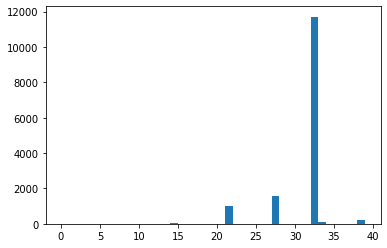

In [40]:
import matplotlib.pyplot as plt
plt.hist(users10['ID_Promotion'], bins = range(0,40,1))

In [41]:
users10['ageBand'].value_counts()

NotAv    7137
20-25    2297
18-20    1456
25-30    1128
30-35     803
35-40     606
40-45     540
45-50     319
50-55     219
55-60     106
60-65      48
65+        27
Name: ageBand, dtype: int64

In [42]:
users10['ageBand'].value_counts()/users10.shape[0]

NotAv    0.485973
20-25    0.156407
18-20    0.099142
25-30    0.076808
30-35    0.054678
35-40    0.041264
40-45    0.036770
45-50    0.021721
50-55    0.014912
55-60    0.007218
60-65    0.003268
65+      0.001838
Name: ageBand, dtype: float64

In [43]:
users10['inf_loginType'].value_counts()/users10.shape[0]   #those receiving the 10euros bonus split by login type

Altri       0.668460
Facebook    0.247038
Google      0.082800
Multi       0.001702
Name: inf_loginType, dtype: float64

In [44]:
funnelusers10Bonus = users10[subset].groupby(["stage","User_Status_Detail","Subscription_Bonus"])["ID_User"].count().reset_index()

C:\Users\elisa\anaconda\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [45]:
funnelStageBonus10 = pd.pivot_table(funnelusers10Bonus, index=["stage","User_Status_Detail"],columns="Subscription_Bonus",values="ID_User",fill_value=0)

funnelProgrSB10 = processFunnelData(funnelStageBonus10.reset_index())


In [46]:
cols10= ['stage','User_Status_Detail','stage_keptOverall','10.0_keptOverall']
funnelProgrSB10[cols10]

Subscription_Bonus,stage,User_Status_Detail,stage_keptOverall,10.0_keptOverall
0,0,0 - E-Mail non verificata,1.000000,1.000000
1,1,1 - Mail Validata,1.000000,0.941849
2,2,2 - Sottoscrizione Iniziata,0.981818,0.750851
3,3,3 - Codice Fiscale OK,0.945455,0.512529
4,4,4 - Dati Personali OK,0.890909,0.479028
5,5,5 - Residenza OK,0.818182,0.441373
6,6,6 - Documento ID OK,0.727273,0.303759
7,7,7 - Documenti Firmati,0.618182,0.291979
8,8,8 - Antiriciclaggio OK,0.490909,0.288574
9,9,9 - Fondo Scelto,0.345455,0.183849


In [47]:
#for those having subscribed in 2019 with a 10.0euros bonus and arrived at the conclusion of the subscription process,
#how long after the subscription did they make the first investment?
a2users.columns #take DateTime_Subscription and DateTime_First_Investment

Index(['ID_User', 'ID_Promotion', 'ID_Promo_Code', 'Age', 'Sex',
       'Email_Domain', 'Flag_User_Disabled', 'Date_Last_Access',
       'Registration_Case', 'Description_Registration_Case',
       'Registration_Step', 'Registration_SubStep',
       'Description_Registration_Step', 'User_Status', 'has_ID_Facebook',
       'has_ID_GPlus', 'User_Class', 'Flag_Test_User', 'Residence_Province',
       'Favourite_Contract_Class', 'Activation_Payment_Method',
       'Payment_Method', 'Subscription_Bonus', 'DateTime_First_Login',
       'First_Login_Type', 'First_Login_Asset', 'DateTime_Last_Login',
       'Last_Login_Type', 'Last_Login_Asset', 'DateTime_Subscription',
       'DateTime_First_Conclusion', 'DateTime_Last_Conclusion',
       'DateTime_First_Investment', 'Last_Online_Subscription',
       'All_Online_Subscriptions', 'User_Status_Detail', 'subscr_year',
       'subscr_month', 'infYear', 'infGender', 'ageAtSubscription', 'ageBand',
       'stage', 'inf_loginType'],
      dtype='obj

In [48]:
concluded10 = users10[users10['stage']==10]
concluded10

,ID_User,ID_Promotion,ID_Promo_Code,Age,Sex,Email_Domain,Flag_User_Disabled,Date_Last_Access,Registration_Case,Description_Registration_Case,...,All_Online_Subscriptions,User_Status_Detail,subscr_year,subscr_month,infYear,infGender,ageAtSubscription,ageBand,stage,inf_loginType
0,1,32,40100.0,44.0,1,GMAIL,0.0,06/09/2019,1.0,Nuovo Utente,...,Gimme5,10 - Concluso,2019,3,1975.0,1,43,40-45,10,Multi
9,10,27,40087.0,43.0,1,HOTMAIL,0.0,05/09/2019,1.0,Nuovo Utente,...,Gimme5,10 - Concluso,2019,3,1976.0,1,43,40-45,10,Facebook
28,29,27,40087.0,24.0,1,GMAIL,0.0,05/09/2019,1.0,Nuovo Utente,...,Gimme5,10 - Concluso,2019,4,1994.0,1,24,20-25,10,Altri
37,38,32,40100.0,27.0,1,GMAIL,0.0,05/09/2019,1.0,Nuovo Utente,...,Gimme5,10 - Concluso,2019,2,1992.0,1,26,25-30,10,Altri
45,46,32,40100.0,42.0,1,GMAIL,0.0,05/09/2019,1.0,Nuovo Utente,...,Gimme5,10 - Concluso,2019,4,1976.0,1,42,40-45,10,Facebook
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169573,169574,27,400870.0,40.0,1,GMAIL,0.0,28/08/2019,1.0,Nuovo Utente,...,Gimme5,10 - Concluso,2019,8,1979.0,1,40,40-45,10,Altri
169626,169627,32,401000.0,41.0,1,GMAIL,0.0,25/08/2019,1.0,Nuovo Utente,...,Gimme5,10 - Concluso,2019,8,1978.0,1,41,40-45,10,Altri
169737,169738,27,400870.0,35.0,1,GMAIL,0.0,29/08/2019,1.0,Nuovo Utente,...,Gimme5,10 - Concluso,2019,8,1983.0,1,35,35-40,10,Altri
170401,170402,32,401000.0,48.0,1,GMAIL,0.0,26/08/2019,1.0,Nuovo Utente,...,Gimme5,10 - Concluso,2019,8,1970.0,1,48,45-50,10,Altri


(array([1.300e+01, 4.000e+00, 0.000e+00, 2.340e+02, 0.000e+00, 6.080e+02,
        1.000e+00, 1.212e+03, 0.000e+00, 6.600e+01]),
 array([10. , 12.9, 15.8, 18.7, 21.6, 24.5, 27.4, 30.3, 33.2, 36.1, 39. ]),
 <a list of 10 Patch objects>)

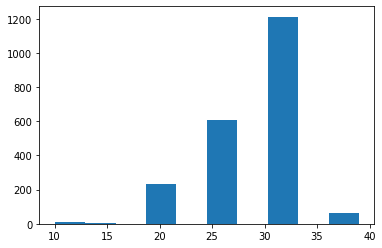

In [49]:
plt.hist(concluded10['ID_Promotion'])

In [50]:
invNA = pd.isna(a2users['DateTime_First_Investment'])
a2users.loc[invNA,'DateTime_First_Investment'] = 0
a2users[a2users['DateTime_First_Investment']!= 0]['DateTime_First_Investment'] #in the whole db we have 9079 customers having already invested
#we want to see the same thing in those having received a 10 bonus in 2019 and having completed subscription

3         19/02/2019 00:00
5         21/02/2018 00:00
6         17/05/2018 00:00
7         18/08/2018 00:00
8         05/09/2019 00:00
                ...       
170658    16/08/2019 00:00
171557    11/06/2019 00:00
171952    18/05/2017 00:00
172059    05/09/2018 00:00
172378    22/03/2018 00:00
Name: DateTime_First_Investment, Length: 9079, dtype: object

In [51]:
invNA = pd.isna(concluded10['DateTime_First_Investment'])
concluded10.loc[invNA,'DateTime_First_Investment'] = 0
concluded10[concluded10['DateTime_First_Investment']!= 0]['DateTime_First_Investment'] #there are 194 people having already invested
#let's call them inv10


C:\Users\elisa\anaconda\lib\site-packages\pandas\core\indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


165       22/07/2019 00:00
171       14/08/2019 00:00
190       26/02/2019 00:00
196       02/04/2019 00:00
380       14/03/2019 00:00
                ...       
163871    26/07/2019 00:00
163936    30/07/2019 00:00
166796    09/08/2019 00:00
168359    21/08/2019 00:00
168865    20/08/2019 00:00
Name: DateTime_First_Investment, Length: 194, dtype: object

In [52]:
inv10 = concluded10[concluded10['DateTime_First_Investment']!= 0]

In [53]:
inv10.shape[0] / concluded10.shape[0] #only the 10% actually invested

0.09073900841908325

In [67]:
#inv10['DateTime_First_Investment']
inv10['DateTime_Subscription']

165      2019-07-17 01:17:00
171      2019-05-04 23:32:00
190      2019-02-20 14:39:00
196      2019-03-27 17:48:00
380      2019-10-03 11:10:00
                 ...        
163871   2019-07-22 13:34:00
163936   2019-07-23 07:47:00
166796   2019-07-30 21:09:00
168359   2019-08-08 17:14:00
168865   2019-12-08 20:22:00
Name: DateTime_Subscription, Length: 194, dtype: datetime64[ns]

In [94]:
inv10['NEWDateTime_First_Investment'] = inv10['DateTime_First_Investment'].dt.strftime('%d/%m/%Y')
inv10['NEWDateTime_First_Investment'] = pd.to_datetime(inv10['NEWDateTime_First_Investment'])

inv10['NEWDateTime_Subscription'] = inv10['DateTime_Subscription'].dt.strftime('%d/%m/%Y')
inv10['NEWDateTime_Subscription'] = pd.to_datetime(inv10['NEWDateTime_Subscription'])


C:\Users\elisa\anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\elisa\anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\elisa\anaconda\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

In [95]:
inv10

,ID_User,ID_Promotion,ID_Promo_Code,Age,Sex,Email_Domain,Flag_User_Disabled,Date_Last_Access,Registration_Case,Description_Registration_Case,...,subscr_month,infYear,infGender,ageAtSubscription,ageBand,stage,inf_loginType,afterwhen,NEWDateTime_First_Investment,NEWDateTime_Subscription
165,166,32,40100.0,36.0,1,GMAIL,0.0,05/09/2019,1.0,Nuovo Utente,...,7,1983.0,1,36,35-40,10,Google,5 days,2019-07-22,2019-07-17
171,172,32,40100.0,26.0,1,GMAIL,0.0,05/09/2019,1.0,Nuovo Utente,...,4,1992.0,1,26,25-30,10,Altri,131 days,2019-08-14,2019-04-05
190,191,32,40100.0,52.0,1,GMAIL,0.0,05/09/2019,1.0,Nuovo Utente,...,2,1966.0,1,52,50-55,10,Altri,6 days,2019-02-26,2019-02-20
196,197,27,40087.0,54.0,1,LIBERO,0.0,05/09/2019,1.0,Nuovo Utente,...,3,1965.0,1,54,50-55,10,Altri,6 days,2019-04-02,2019-03-27
380,381,32,40100.0,54.0,1,LIBERO,0.0,05/09/2019,1.0,Nuovo Utente,...,3,1965.0,1,54,50-55,10,Altri,4 days,2019-03-14,2019-03-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163871,163872,32,401000.0,34.0,1,GMAIL,0.0,16/08/2019,1.0,Nuovo Utente,...,7,1985.0,1,34,30-35,10,Altri,4 days,2019-07-26,2019-07-22
163936,163937,27,400870.0,39.0,1,GMAIL,0.0,11/08/2019,1.0,Nuovo Utente,...,7,1980.0,1,39,35-40,10,Google,7 days,2019-07-30,2019-07-23
166796,166797,32,401000.0,43.0,1,HOTMAIL,0.0,30/08/2019,1.0,Nuovo Utente,...,7,1975.0,1,43,40-45,10,Altri,10 days,2019-08-09,2019-07-30
168359,168360,39,401210.0,31.0,1,OUTLOOK,0.0,30/08/2019,1.0,Nuovo Utente,...,8,1988.0,1,31,30-35,10,Altri,13 days,2019-08-21,2019-08-08


In [96]:
inv10['afterwhen10'] = (inv10['NEWDateTime_First_Investment']- inv10['NEWDateTime_Subscription'])

C:\Users\elisa\anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [97]:
inv10[['ID_User', 'DateTime_Subscription', 'DateTime_First_Investment', 'afterwhen10']]

,ID_User,DateTime_Subscription,DateTime_First_Investment,afterwhen
165,166,2019-07-17 01:17:00,2019-07-22,5 days
171,172,2019-05-04 23:32:00,2019-08-14,131 days
190,191,2019-02-20 14:39:00,2019-02-26,6 days
196,197,2019-03-27 17:48:00,2019-02-04,6 days
380,381,2019-10-03 11:10:00,2019-03-14,4 days
...,...,...,...,...
163871,163872,2019-07-22 13:34:00,2019-07-26,4 days
163936,163937,2019-07-23 07:47:00,2019-07-30,7 days
166796,166797,2019-07-30 21:09:00,2019-09-08,10 days
168359,168360,2019-08-08 17:14:00,2019-08-21,13 days


In [98]:
type(inv10['afterwhen10'])

pandas.core.series.Series

In [99]:
print(inv10['afterwhen10'].mean())
print(inv10['afterwhen10'].max())
print(inv10['afterwhen10'].min())

18 days 22:45:46.391752577
159 days 00:00:00
3 days 00:00:00


### Some analysis on those having received the 15.0 euros bonus

In [143]:
users15 = users15[subset]

C:\Users\elisa\anaconda\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [145]:
users15['ID_Promotion'].value_counts() #for 15 euros bonus the codes were 23 

23    29
Name: ID_Promotion, dtype: int64

In [146]:
users15['inf_loginType'].value_counts()/users15.shape[0]  #they mostly subscribed through other ways than FB or Google

Altri       0.655172
Facebook    0.172414
Google      0.137931
Multi       0.034483
Name: inf_loginType, dtype: float64

In [147]:
users15['ageBand'].value_counts()  #the segment using this code is in the 25-30 yo stage

25-30    10
30-35     4
20-25     4
35-40     3
NotAv     3
40-45     2
50-55     1
45-50     1
55-60     1
Name: ageBand, dtype: int64

In [148]:
users15.shape

(29, 44)

In [149]:
users15['ageBand'].value_counts()/users15.shape[0]   #Since the age is available only after the 2nd step, once included the
                                                     #fiscal code, from Na we see that small % of those having received the 
                                                     #15.0 bonus quit before giving the fiscal code

25-30    0.344828
30-35    0.137931
20-25    0.137931
35-40    0.103448
NotAv    0.103448
40-45    0.068966
50-55    0.034483
45-50    0.034483
55-60    0.034483
Name: ageBand, dtype: float64

In [150]:
funnelusers15Bonus = users15[subset].groupby(["stage","User_Status_Detail","Subscription_Bonus"])["ID_User"].count().reset_index()

C:\Users\elisa\anaconda\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [151]:
funnelStageBonus15 = pd.pivot_table(funnelusers15Bonus, index=["stage","User_Status_Detail"],columns="Subscription_Bonus",values="ID_User",fill_value=0)

funnelProgrSB15 = processFunnelData(funnelStageBonus15.reset_index())
cols15 = ['stage','User_Status_Detail','stage_keptOverall','15.0_keptOverall']
funnelProgrSB15[cols15]

Subscription_Bonus,stage,User_Status_Detail,stage_keptOverall,15.0_keptOverall
0,1,1 - Mail Validata,1.000000,1.000000
1,3,3 - Codice Fiscale OK,0.976190,0.896552
2,5,5 - Residenza OK,0.904762,0.862069
3,6,6 - Documento ID OK,0.785714,0.724138
4,8,8 - Antiriciclaggio OK,0.642857,0.689655
5,9,9 - Fondo Scelto,0.452381,0.586207
6,10,10 - Concluso,0.238095,0.551724


In [100]:
concluded15 = users15[users15['stage']==10]
concluded15

,ID_User,ID_Promotion,ID_Promo_Code,Age,Sex,Email_Domain,Flag_User_Disabled,Date_Last_Access,Registration_Case,Description_Registration_Case,...,All_Online_Subscriptions,User_Status_Detail,subscr_year,subscr_month,infYear,infGender,ageAtSubscription,ageBand,stage,inf_loginType
75,76,23,40083.0,36.0,1,GMAIL,0.0,05/09/2019,1.0,Nuovo Utente,...,Gimme5,10 - Concluso,2019,7,1982.0,1,36,35-40,10,Altri
1000,1001,23,40083.0,26.0,1,HOTMAIL,0.0,05/09/2019,1.0,Nuovo Utente,...,Gimme5,10 - Concluso,2019,4,1993.0,1,26,25-30,10,Altri
3508,3509,9,40057.0,29.0,2,HOTMAIL,0.0,04/09/2019,1.0,Nuovo Utente,...,Gimme5,10 - Concluso,2018,5,1990.0,2,27,25-30,10,Altri
4871,4872,23,40083.0,25.0,1,GMAIL,0.0,03/09/2019,1.0,Nuovo Utente,...,Gimme5,10 - Concluso,2019,1,1994.0,1,24,20-25,10,Altri
5325,5326,23,40083.0,28.0,1,HOTMAIL,0.0,03/09/2019,1.0,Nuovo Utente,...,Gimme5,10 - Concluso,2019,5,1991.0,1,28,25-30,10,Facebook
5497,5498,23,40083.0,40.0,1,TREE,0.0,02/09/2019,1.0,Nuovo Utente,...,Gimme5,10 - Concluso,2019,2,1978.0,1,40,40-45,10,Altri
6227,6228,23,40083.0,24.0,1,HOTMAIL,0.0,02/09/2019,1.0,Nuovo Utente,...,Gimme5,10 - Concluso,2018,12,1994.0,1,23,20-25,10,Altri
6626,6627,23,40083.0,54.0,1,TISCALI,0.0,01/09/2019,1.0,Nuovo Utente,...,Gimme5,10 - Concluso,2019,3,1964.0,1,54,50-55,10,Multi
6905,6906,23,40083.0,29.0,1,GMAIL,0.0,01/09/2019,1.0,Nuovo Utente,...,Gimme5,10 - Concluso,2019,1,1990.0,1,28,25-30,10,Altri
7151,7152,23,40083.0,23.0,1,GMAIL,0.0,31/08/2019,1.0,Nuovo Utente,...,Gimme5,10 - Concluso,2018,12,1996.0,1,22,20-25,10,Altri


(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 20.]),
 array([ 9. , 10.4, 11.8, 13.2, 14.6, 16. , 17.4, 18.8, 20.2, 21.6, 23. ]),
 <a list of 10 Patch objects>)

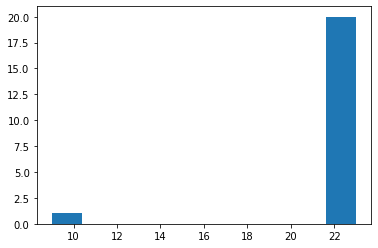

In [101]:
plt.hist(concluded15['ID_Promotion'])

In [102]:
inv15NA = pd.isna(concluded15['DateTime_First_Investment'])
concluded15.loc[inv15NA,'DateTime_First_Investment'] = 0
concluded15[concluded15['DateTime_First_Investment']!= 0]['DateTime_First_Investment'] #there are 194 people having already invested
#let's call them inv15


C:\Users\elisa\anaconda\lib\site-packages\pandas\core\indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


135473    17/01/2019 00:00
162066    09/07/2019 00:00
Name: DateTime_First_Investment, dtype: object

In [103]:
inv15 = concluded15[concluded15['DateTime_First_Investment']!= 0]

In [104]:
inv15.shape[0]/concluded15.shape[0] #same % as before: only the 10% actually invests even if they subscribe

0.09523809523809523

In [128]:
inv15['NEWDateTime_First_Investment'] = pd.to_datetime(inv15['DateTime_First_Investment'])
inv15['NEWDateTime_Subscription'] = pd.to_datetime(inv15['DateTime_Subscription'])


C:\Users\elisa\anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\elisa\anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [129]:
inv15[['DateTime_Subscription', 'DateTime_First_Investment','NEWDateTime_Subscription', 'NEWDateTime_First_Investment']]

,DateTime_Subscription,DateTime_First_Investment,NEWDateTime_Subscription,NEWDateTime_First_Investment
135473,2019-06-01 23:43:00,17/01/2019 00:00,2019-06-01 23:43:00,2019-01-17
162066,2019-04-07 15:34:00,09/07/2019 00:00,2019-04-07 15:34:00,2019-09-07


In [130]:
inv15['NEWDateTime_Subscription'] = pd.to_datetime(inv15['NEWDateTime_Subscription'])
inv15['NEWDateTime_First_Investment'] = pd.to_datetime(inv15['NEWDateTime_First_Investment'])

C:\Users\elisa\anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\elisa\anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [131]:
type(inv15['NEWDateTime_Subscription'])

pandas.core.series.Series

In [132]:
type(inv15['NEWDateTime_First_Investment'])

pandas.core.series.Series

In [134]:
inv15['NEWDateTime_First_Investment'] = inv15['NEWDateTime_First_Investment'].dt.strftime('%d/%m/%Y')
inv15['NEWDateTime_Subscription'] = inv15['NEWDateTime_Subscription'].dt.strftime('%d/%m/%Y')


C:\Users\elisa\anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\elisa\anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [136]:
inv15['NEWDateTime_First_Investment'] = pd.to_datetime(inv15['NEWDateTime_First_Investment'])

inv15['NEWDateTime_Subscription'] = pd.to_datetime(inv15['NEWDateTime_Subscription'])


C:\Users\elisa\anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\elisa\anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [137]:
inv15['afterwhen15'] = (inv15['NEWDateTime_First_Investment']- inv15['NEWDateTime_Subscription'])

C:\Users\elisa\anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [138]:
inv15 #we can see that the two ones having received the 15 euros bonus invested after few days

,ID_User,ID_Promotion,ID_Promo_Code,Age,Sex,Email_Domain,Flag_User_Disabled,Date_Last_Access,Registration_Case,Description_Registration_Case,...,subscr_month,infYear,infGender,ageAtSubscription,ageBand,stage,inf_loginType,NEWDateTime_First_Investment,NEWDateTime_Subscription,afterwhen
135473,135474,23,400830.0,27.0,1,GMAIL,0.0,25/07/2019,1.0,Nuovo Utente,...,1,1992.0,1,26,25-30,10,Altri,2019-01-17,2019-01-06,11 days
162066,162067,23,400830.0,44.0,1,COPPOLAB,0.0,01/08/2019,1.0,Nuovo Utente,...,7,1975.0,1,44,40-45,10,Altri,2019-07-09,2019-07-04,5 days


### Some analysis on those having received the 5.0 euros bonus

In [152]:
users5= users5[subset]

C:\Users\elisa\anaconda\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [153]:
users5['ID_Promotion'].value_counts() #35 is the code for the MGM promotion

35    2254
36     422
37     387
13     358
24     318
30      63
12      38
17      21
18      15
34      14
25       3
29       1
Name: ID_Promotion, dtype: int64

(array([0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        3.800e+01, 3.580e+02, 0.000e+00, 0.000e+00, 0.000e+00, 2.100e+01,
        1.500e+01, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        3.180e+02, 3.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        6.300e+01, 0.000e+00, 0.000e+00, 0.000e+00, 1.400e+01, 2.254e+03,
        4.220e+02, 3.870e+02, 0.000e+00]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39]),
 <a list of 39 Patch objects>)

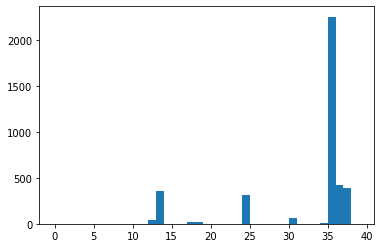

In [154]:
plt.hist(users5['ID_Promotion'], bins = range(0,40))

In [155]:
users5['inf_loginType'].value_counts()/users5.shape[0]  #also in this case the way they start subscription process is mainly different from FB or Google

Altri       0.765280
Facebook    0.122496
Google      0.109913
Multi       0.002311
Name: inf_loginType, dtype: float64

In [156]:
users5['ageBand'].value_counts()

NotAv    1027
20-25     664
25-30     510
18-20     434
30-35     410
35-40     334
40-45     224
45-50     133
50-55      85
55-60      39
60-65      22
65+        12
Name: ageBand, dtype: int64

In [157]:
users5['ageBand'].value_counts()/users5.shape[0] #in this case there is a high percentage of people lost when asking fiscal code

NotAv    0.263739
20-25    0.170519
25-30    0.130971
18-20    0.111454
30-35    0.105290
35-40    0.085773
40-45    0.057524
45-50    0.034155
50-55    0.021828
55-60    0.010015
60-65    0.005650
65+      0.003082
Name: ageBand, dtype: float64

In [158]:
funnelusers5Bonus = users5[subset].groupby(["stage","User_Status_Detail","Subscription_Bonus"])["ID_User"].count().reset_index()

C:\Users\elisa\anaconda\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [159]:
funnelStageBonus5 = pd.pivot_table(funnelusers5Bonus, index=["stage","User_Status_Detail"],columns="Subscription_Bonus",values="ID_User",fill_value=0)

funnelProgrSB5 = processFunnelData(funnelStageBonus5.reset_index())
cols5 = ['stage','User_Status_Detail','stage_keptOverall','5.0_keptOverall']
funnelProgrSB5[cols5]

Subscription_Bonus,stage,User_Status_Detail,stage_keptOverall,5.0_keptOverall
0,0,0 - E-Mail non verificata,1.000000,1.000000
1,1,1 - Mail Validata,1.000000,0.965588
2,2,2 - Sottoscrizione Iniziata,0.981818,0.884181
3,3,3 - Codice Fiscale OK,0.945455,0.735747
4,4,4 - Dati Personali OK,0.890909,0.690293
5,5,5 - Residenza OK,0.818182,0.641757
6,6,6 - Documento ID OK,0.727273,0.476374
7,7,7 - Documenti Firmati,0.618182,0.460452
8,8,8 - Antiriciclaggio OK,0.490909,0.457370
9,9,9 - Fondo Scelto,0.345455,0.334617


In [160]:
#is there a variable indicating where did they hear about Gimme5 for the first time?
#to understand which marketing channel is performing better for this product and if there are any differences in the completed
#subscription steps for customers coming from different marketing channels

In [139]:
concluded5 = users5[users5['stage']==10]
concluded5

,ID_User,ID_Promotion,ID_Promo_Code,Age,Sex,Email_Domain,Flag_User_Disabled,Date_Last_Access,Registration_Case,Description_Registration_Case,...,All_Online_Subscriptions,User_Status_Detail,subscr_year,subscr_month,infYear,infGender,ageAtSubscription,ageBand,stage,inf_loginType
2,3,35,40103.0,28.0,1,GMAIL,0.0,05/09/2019,1.0,Nuovo Utente,...,Gimme5,10 - Concluso,2019,3,1990.0,1,28,25-30,10,Altri
10,11,24,40084.0,29.0,2,GMAIL,0.0,05/09/2019,1.0,Nuovo Utente,...,Gimme5,10 - Concluso,2019,2,1990.0,2,29,25-30,10,Altri
13,14,13,40067.0,31.0,1,ICLOUD,0.0,06/09/2019,1.0,Nuovo Utente,...,Gimme5,10 - Concluso,2019,6,1987.0,1,31,30-35,10,Multi
21,22,35,40103.0,29.0,1,HOTMAIL,0.0,05/09/2019,1.0,Nuovo Utente,...,Gimme5,10 - Concluso,2019,4,1989.0,1,29,25-30,10,Altri
23,24,35,40103.0,38.0,1,GMAIL,0.0,05/09/2019,1.0,Nuovo Utente,...,Gimme5,10 - Concluso,2018,9,1980.0,1,37,35-40,10,Altri
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170447,170448,35,401030.0,18.0,1,GMAIL,0.0,26/08/2019,1.0,Nuovo Utente,...,Gimme5,10 - Concluso,2019,8,2001.0,1,18,18-20,10,Altri
170553,170554,35,401030.0,36.0,1,GMAIL,0.0,27/08/2019,1.0,Nuovo Utente,...,Gimme5,10 - Concluso,2019,8,1983.0,1,36,35-40,10,Altri
170665,170666,35,401030.0,37.0,2,HOTMAIL,0.0,28/08/2019,1.0,Nuovo Utente,...,Gimme5,10 - Concluso,2019,8,1982.0,2,37,35-40,10,Facebook
170823,170824,35,401030.0,29.0,1,GMAIL,0.0,29/08/2019,1.0,Nuovo Utente,...,Gimme5,10 - Concluso,2019,8,1989.0,1,29,25-30,10,Altri


(array([228.,   0., 228.,   0.,  39.,   5.,   1.,  23.,   5., 976.]),
 array([12. , 14.5, 17. , 19.5, 22. , 24.5, 27. , 29.5, 32. , 34.5, 37. ]),
 <a list of 10 Patch objects>)

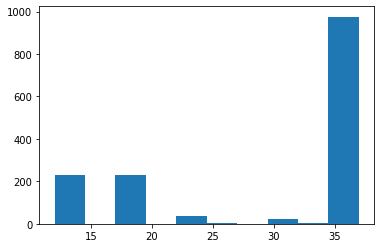

In [140]:
plt.hist(concluded5['ID_Promotion'])

In [141]:
inv5NA = pd.isna(concluded5['DateTime_First_Investment'])
concluded5.loc[inv5NA,'DateTime_First_Investment'] = 0
concluded5[concluded5['DateTime_First_Investment']!= 0]['DateTime_First_Investment'] #there are 194 people having already invested
#let's call them inv5


C:\Users\elisa\anaconda\lib\site-packages\pandas\core\indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


10        21/02/2019 00:00
83        30/08/2019 00:00
122       24/05/2019 00:00
224       23/08/2019 00:00
247       05/07/2019 00:00
                ...       
167089    08/08/2019 00:00
168694    16/08/2019 00:00
168905    28/08/2019 00:00
169167    20/08/2019 00:00
169714    23/08/2019 00:00
Name: DateTime_First_Investment, Length: 217, dtype: object

In [143]:
inv5 = concluded5[concluded5['DateTime_First_Investment']!= 0]
inv5

,ID_User,ID_Promotion,ID_Promo_Code,Age,Sex,Email_Domain,Flag_User_Disabled,Date_Last_Access,Registration_Case,Description_Registration_Case,...,All_Online_Subscriptions,User_Status_Detail,subscr_year,subscr_month,infYear,infGender,ageAtSubscription,ageBand,stage,inf_loginType
10,11,24,40084.0,29.0,2,GMAIL,0.0,05/09/2019,1.0,Nuovo Utente,...,Gimme5,10 - Concluso,2019,2,1990.0,2,29,25-30,10,Altri
83,84,35,40103.0,30.0,1,HOTMAIL,0.0,05/09/2019,1.0,Nuovo Utente,...,Gimme5,10 - Concluso,2019,8,1988.0,1,30,30-35,10,Facebook
122,123,35,40103.0,27.0,1,HOTMAIL,0.0,05/09/2019,1.0,Nuovo Utente,...,Gimme5,10 - Concluso,2019,5,1992.0,1,26,25-30,10,Altri
224,225,35,40103.0,23.0,1,GMAIL,0.0,05/09/2019,1.0,Nuovo Utente,...,Gimme5,10 - Concluso,2019,8,1995.0,1,23,20-25,10,Altri
247,248,13,40067.0,26.0,1,GMAIL,0.0,05/09/2019,1.0,Nuovo Utente,...,Gimme5,10 - Concluso,2019,7,1992.0,1,26,25-30,10,Altri
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167089,167090,35,401030.0,23.0,1,HOTMAIL,0.0,28/08/2019,1.0,Nuovo Utente,...,Gimme5,10 - Concluso,2019,8,1995.0,1,23,20-25,10,Altri
168694,168695,35,401030.0,20.0,1,GMAIL,0.0,29/08/2019,1.0,Nuovo Utente,...,Gimme5,10 - Concluso,2019,8,1999.0,1,20,20-25,10,Altri
168905,168906,17,400750.0,45.0,1,GMAIL,0.0,29/08/2019,1.0,Nuovo Utente,...,Gimme5,10 - Concluso,2019,8,1974.0,1,45,45-50,10,Altri
169167,169168,35,401030.0,37.0,1,GMAIL,0.0,30/08/2019,1.0,Nuovo Utente,...,Gimme5,10 - Concluso,2019,8,1982.0,1,37,35-40,10,Altri


In [144]:
inv5.shape[0]/concluded5.shape[0] # only the 15% actually invests even if they subscribe


0.14418604651162792

In [145]:
inv5['NEWDateTime_First_Investment'] = pd.to_datetime(inv5['DateTime_First_Investment'])
inv5['NEWDateTime_Subscription'] = pd.to_datetime(inv5['DateTime_Subscription'])


C:\Users\elisa\anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\elisa\anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [147]:
inv5[['DateTime_Subscription', 'DateTime_First_Investment','NEWDateTime_Subscription', 'NEWDateTime_First_Investment']]

,DateTime_Subscription,DateTime_First_Investment,NEWDateTime_Subscription,NEWDateTime_First_Investment
10,2019-02-15 17:35:00,21/02/2019 00:00,2019-02-15 17:35:00,2019-02-21
83,2019-10-08 22:27:00,30/08/2019 00:00,2019-10-08 22:27:00,2019-08-30
122,2019-05-21 16:54:00,24/05/2019 00:00,2019-05-21 16:54:00,2019-05-24
224,2019-02-08 16:20:00,23/08/2019 00:00,2019-02-08 16:20:00,2019-08-23
247,2019-02-07 13:43:00,05/07/2019 00:00,2019-02-07 13:43:00,2019-05-07
...,...,...,...,...
167089,2019-02-08 23:05:00,08/08/2019 00:00,2019-02-08 23:05:00,2019-08-08
168694,2019-11-08 13:50:00,16/08/2019 00:00,2019-11-08 13:50:00,2019-08-16
168905,2019-08-13 09:10:00,28/08/2019 00:00,2019-08-13 09:10:00,2019-08-28
169167,2019-08-15 10:41:00,20/08/2019 00:00,2019-08-15 10:41:00,2019-08-20


In [153]:
inv5['NEWDateTime_Subscription'] = pd.to_datetime(inv5['NEWDateTime_Subscription'])
inv5['NEWDateTime_First_Investment'] = pd.to_datetime(inv5['NEWDateTime_First_Investment'])


C:\Users\elisa\anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\elisa\anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [154]:
inv5['NEWDateTime_First_Investment'] = inv5['NEWDateTime_First_Investment'].dt.strftime('%d/%m/%Y')
inv5['NEWDateTime_Subscription'] = inv5['NEWDateTime_Subscription'].dt.strftime('%d/%m/%Y')



C:\Users\elisa\anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\elisa\anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [155]:
inv5['NEWDateTime_First_Investment'] = pd.to_datetime(inv5['NEWDateTime_First_Investment'])
inv5['NEWDateTime_Subscription'] = pd.to_datetime(inv5['NEWDateTime_Subscription'])

C:\Users\elisa\anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\elisa\anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [158]:
inv5['afterwhen5'] = (inv5['NEWDateTime_First_Investment']- inv5['NEWDateTime_Subscription'])
inv5['afterwhen5']

C:\Users\elisa\anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


10        6 days
83       20 days
122       3 days
224      21 days
247       3 days
           ...  
167089    6 days
168694    5 days
168905   15 days
169167    5 days
169714    4 days
Name: afterwhen5, Length: 217, dtype: timedelta64[ns]

In [160]:
print(inv5['afterwhen5'].mean())
print(inv5['afterwhen5'].max())
print(inv5['afterwhen5'].min()) #we can see that in mean they spend more time from the subscription to the first investment, sometimes also 2 years!

35 days 10:03:52.258064516
646 days 00:00:00
3 days 00:00:00


Remember that 15euros bonus is given to very few people!
Seems people is sensitive to have or not a bonus but not to the amount of the bonus

### Analisi del funnel sezionata per tipo di login (ripetuta utilizzando solo i dati 2019).

In [59]:
tgt_year = 2019

funnelDataLog_y = a2users[a2users["subscr_year"]==tgt_year].groupby(["stage","User_Status_Detail","inf_loginType"])["ID_User"].count().reset_index()
funnelStageLog_y = pd.pivot_table(funnelDataLog_y, index=["stage","User_Status_Detail"],columns="inf_loginType",values="ID_User",fill_value=0)

funnelProgrSL_y = processFunnelData(funnelStageLog_y.reset_index())
funnelProgrSL_y[["User_Status_Detail","Altri","Facebook","Google","Multi","Altri_keptOverall","Facebook_keptOverall","Google_keptOverall","Multi_keptOverall"]]

inf_loginType,User_Status_Detail,Altri,Facebook,Google,Multi,Altri_keptOverall,Facebook_keptOverall,Google_keptOverall,Multi_keptOverall
0,0 - E-Mail non verificata,3265,0,0,0,1.000000,1.000000,1.000000,1.000000
1,1 - Mail Validata,3203,2568,1096,3,0.890086,1.000000,1.000000,1.000000
2,2 - Sottoscrizione Iniziata,9923,2965,2665,22,0.782259,0.657874,0.799561,0.955224
3,3 - Codice Fiscale OK,863,165,127,1,0.448207,0.262856,0.312180,0.626866
4,4 - Dati Personali OK,846,221,123,0,0.419155,0.240874,0.288954,0.611940
5,5 - Residenza OK,3173,614,385,0,0.390675,0.211431,0.266459,0.611940
6,6 - Documento ID OK,404,49,46,0,0.283858,0.129630,0.196050,0.611940
7,7 - Documenti Firmati,92,11,7,0,0.270258,0.123102,0.187637,0.611940
8,8 - Antiriciclaggio OK,2594,361,307,2,0.267160,0.121636,0.186357,0.611940
9,9 - Fondo Scelto,684,75,78,4,0.179835,0.073541,0.130212,0.582090


Analisi del funnel sezionata per età delle leads.

**ATTENZIONE**: l'età è calcolabile/disponibile solo **dopo** che la lead ha registrato il codice fiscale. Per questo motivo l'analisi non include gli stati precedenti.

In [53]:
tgt_year = 2019

subset = (a2users["subscr_year"]==tgt_year) & (a2users["stage"]>2)
funnelDataAge = a2users[subset].groupby(["stage","User_Status_Detail","ageBand"])["ID_User"].count().reset_index()
del subset

funnelStageAge = pd.pivot_table(funnelDataAge, index=["stage","User_Status_Detail"],columns="ageBand",values="ID_User",fill_value=0)

funnelProgrSA = processFunnelData(funnelStageAge.reset_index())

Confronto delle statistiche della completion rate per ogni stage del funnel per fasce di età. La statistica scelta è la completion rate che è più semplicemente confrontabile con l'analisi aggregata (senza divisione per età). Per utilizzare le altre statistiche, si ricordi che in questa fase si sta considerando come step 0 l'inserimento del codice fiscale (dato che prima di quel momento non è possibile determinare l'età della lead).

In [54]:
# ATTENZIONE: se si decide di utilizzare _keptOverall come statistica
# si ricordi che la baseline (100%) non è più il numero di leads create
# ma il numero di leads che hanno inserito il codice fiscale. Questo rende
# la statistica non confrontabile con le analisi precedenti.
#cols = ["Stato_Utente"] + [x for x in funnelProgrSA.columns if "_keptOverall" in x]
cols = ["User_Status_Detail"] + [x for x in funnelProgrSA.columns if "_keptStage" in x]
funnelProgrSA[cols]

ageBand,User_Status_Detail,stage_keptStage,18-20_keptStage,20-25_keptStage,25-30_keptStage,30-35_keptStage,35-40_keptStage,40-45_keptStage,45-50_keptStage,50-55_keptStage,55-60_keptStage,60-65_keptStage,65+_keptStage,NotAv_keptStage
0,3 - Codice Fiscale OK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4 - Dati Personali OK,0.942308,0.841276,0.954749,0.949565,0.953733,0.946667,0.944166,0.944269,0.935540,0.881188,0.947368,0.900000,0.666667
2,5 - Residenza OK,0.918367,0.935393,0.918785,0.928938,0.927474,0.919780,0.932525,0.920935,0.918063,0.910112,0.928571,0.898990,1.000000
3,6 - Documento ID OK,0.888889,0.711211,0.711983,0.723975,0.720352,0.721704,0.711382,0.724305,0.705882,0.711934,0.709402,0.629213,1.000000
4,7 - Documenti Firmati,0.850000,0.957776,0.955094,0.950980,0.955428,0.953875,0.936000,0.961603,0.945402,0.936416,0.915663,0.964286,1.000000
5,8 - Antiriciclaggio OK,0.794118,0.985305,0.990122,0.985109,0.992476,0.994197,0.993895,0.980903,0.984802,0.987654,1.000000,1.000000,1.000000
6,9 - Fondo Scelto,0.703704,0.604027,0.638468,0.674419,0.686126,0.707198,0.718673,0.699115,0.756173,0.718750,0.750000,0.814815,1.000000
7,10 - Concluso,0.526316,0.703704,0.829375,0.892241,0.930387,0.925722,0.955556,0.924051,0.946939,0.947826,0.807018,1.000000,1.000000


Visulizzazione di tutte le statistiche di progressione nel funnel per una singola fascia di età.

In [59]:
ageBands = ["18-20","20-25","25-30","30-35","35-40","40-45","45-50","50-55","55-60","60-65","65+"]

ageBand = ageBands[1]
cols = ["User_Status_Detail"] + [x for x in funnelProgrSA.columns if ageBand in x]

funnelProgrSA[cols]

ageBand,User_Status_Detail,20-25,20-25_funnelProgression,20-25_startingFrom,20-25_stageLoss,20-25_keptStage,20-25_keptOverall
0,3 - Codice Fiscale OK,192,4243,NaN,NaN,NaN,1.000000
1,4 - Dati Personali OK,329,4051,4243.0,-192.0,0.954749,0.954749
2,5 - Residenza OK,1072,3722,4051.0,-329.0,0.918785,0.877210
3,6 - Documento ID OK,119,2650,3722.0,-1072.0,0.711983,0.624558
4,7 - Documenti Firmati,25,2531,2650.0,-119.0,0.955094,0.596512
5,8 - Antiriciclaggio OK,906,2506,2531.0,-25.0,0.990122,0.590620
6,9 - Fondo Scelto,273,1600,2506.0,-906.0,0.638468,0.377092
7,10 - Concluso,1327,1327,1600.0,-273.0,0.829375,0.312750
